# 1 Transfer Stations

- `MRT-Transfer-Stations-Raw.csv`

- `MRT-Transfer-Stations.csv`

In [28]:
import sys
import itertools
import pandas as pd

data = pd.read_csv('MRT-Transfer-Stations-Raw.csv', skip_blank_lines=True, comment='#')
# data['closed'] = ''
# data.to_csv('MRT-Transfer-Stations-Raw.csv', index=False)

data['num'] = data['all_station_codes'].str.split(' ').str.len()

data['all_station_codes'] = data['all_station_codes'].apply(
    lambda x: ' '.join(list(sorted(x.split(' '))))
    )

data = data.drop_duplicates(ignore_index=True)


try:
    # check that whether there exists repeated station
    stn_codes = data['all_station_codes'].str.split(' ').to_list()
    all_stn = list(itertools.chain.from_iterable(stn_codes)) 

    assert len(all_stn) == len(set(all_stn))
except:
    print(len(all_stn), len(set(all_stn)))
    sys.exit(0)
    pass

data.to_csv('MRT-Transfer-Stations.csv', index=False)

# 2 Extract MRT Line

In [29]:
! pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import sys
import itertools

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString

In [31]:
def obtain_line_segement_geo(start_stn, end_stn, stn_gpd):
    '''

    Args:
        start_stn (str): start staion code.
        end_stn (str): end station code.
        stn_gpd (geopandas.GeoDataFrame): DESCRIPTION.

    Returns:
        line (TYPE): DESCRIPTION.

    '''
    stn_list = stn_gpd['all_station_codes'].str.split(' ').to_list()
    
    start_geo = stn_gpd[[start_stn in x for x in stn_list]]
    end_geo   = stn_gpd[[end_stn in x for x in stn_list]] 
    
    assert (start_geo.shape[0] == 1) and (end_geo.shape[0] == 1)
    
    start_geo = start_geo.squeeze()
    end_geo   = end_geo.squeeze()
    
    line = LineString([start_geo['geometry'], end_geo['geometry']])
    return line

## 2.1 Read Data

In [32]:
'''
line_df = pd.read_csv('MRT-Line-Codes.csv', skip_blank_lines=True)

stn_df = pd.read_csv('MRT-Station-Codes.csv', comment='#', skip_blank_lines=True)

transfer_df = pd.read_csv('MRT-Transfer-Stations.csv', comment='#', skip_blank_lines=True)

line_com_df = pd.read_csv('MRT-Loop-Line-Complement.csv', skip_blank_lines=True)

stn_gpd = gpd.read_file("zip://TrainStation_Jan2022.zip!TrainStation_Jan2022/MRTLRTStnPtt.shp")
'''

'\nline_df = pd.read_csv(\'MRT-Line-Codes.csv\', skip_blank_lines=True)\n\nstn_df = pd.read_csv(\'MRT-Station-Codes.csv\', comment=\'#\', skip_blank_lines=True)\n\ntransfer_df = pd.read_csv(\'MRT-Transfer-Stations.csv\', comment=\'#\', skip_blank_lines=True)\n\nline_com_df = pd.read_csv(\'MRT-Loop-Line-Complement.csv\', skip_blank_lines=True)\n\nstn_gpd = gpd.read_file("zip://TrainStation_Jan2022.zip!TrainStation_Jan2022/MRTLRTStnPtt.shp")\n'

In [33]:
line_df = pd.read_csv('https://raw.githubusercontent.com/veager/GeoDatabase-Singapore/main/MRT-Train/Network/MRT-Line-Codes.csv', 
                     comment='#', skip_blank_lines=True)

stn_df = pd.read_csv('https://raw.githubusercontent.com/veager/GeoDatabase-Singapore/main/MRT-Train/Network/MRT-Station-Codes.csv', 
                     comment='#', skip_blank_lines=True)

transfer_df = pd.read_csv('https://raw.githubusercontent.com/veager/GeoDatabase-Singapore/main/MRT-Train/Network/MRT-Transfer-Stations.csv', 
                          comment='#', skip_blank_lines=True)

line_com_df = pd.read_csv('https://raw.githubusercontent.com/veager/GeoDatabase-Singapore/main/MRT-Train/Network/MRT-Loop-Line-Complement.csv', 
                          skip_blank_lines=True)

stn_gpd = gpd.read_file("zip://TrainStation_Jan2022.zip!TrainStation_Jan2022/MRTLRTStnPtt.shp")

## 2.2 Parameters

In [34]:
# CRS
CRS = stn_gpd.crs

# closed station codes
CLOSED_STN_CODES = stn_df[stn_df['closed'] == True]['stn_code'].to_list()
# ['BP14', 'DT4', 'CC18', 'PW2']

# transfer station code
TRANSFER_STN_CODE = transfer_df['all_station_codes'].str.split(' ').to_list()
_all_stn_codes = list(itertools.chain.from_iterable(TRANSFER_STN_CODE))
assert len(_all_stn_codes) == len(set(_all_stn_codes))

## 2.3 Station Geographic Location

- `TrainStation.zip`

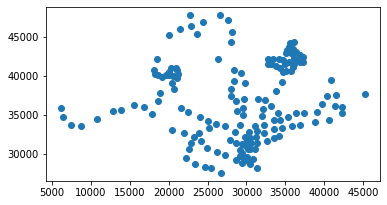

In [35]:
# handle the ".shp"
stn_gpd['all_station_codes'] = ''

for row_ix, row in stn_gpd.iterrows():
    
    stn_code_li = stn_gpd.loc[row_ix, 'STN_NO'].split('/')
    
    if set(stn_code_li).issubset(set(CLOSED_STN_CODES)):
        # print(stn_code_li)
        stn_gpd.loc[row_ix, 'all_station_codes'] = 'closed_station'
    else:
        # find the 
        stn_code = stn_code_li[0]
        ix = [stn_code in x for x in TRANSFER_STN_CODE]
        ix = ix.index(True)  
        # print(ix)
        stn_gpd.loc[row_ix, 'all_station_codes'] = ' '.join(TRANSFER_STN_CODE[ix])

# drop closed station from "stn_gpd"
stn_gpd = stn_gpd[~ (stn_gpd['all_station_codes'] == 'closed_station')]

# the location transfer station will be the center of 
# the same name stations in the between lines
stn_gpd = stn_gpd.dissolve('all_station_codes', aggfunc='first', as_index=False)
stn_gpd['geometry'] = stn_gpd['geometry'].centroid
stn_gpd = stn_gpd.reset_index(drop=True)

stn_gpd.plot()

## 2.4 Station Codes

Merge *Station Codes* and *Line Codes*

- `MRT-Station-Codes.csv`

- `MRT-Line-Codes.csv`

In [36]:
# drop closed station from "stn_df" data
stn_df = stn_df[~ (stn_df['closed'] == True)]
stn_df.reset_index(drop=True, inplace=True)
stn_df.drop(['mrt_line_english', 'openning_date', 'closed_date', 'closed'], axis=1, inplace=True)

stn_df = stn_df.merge(right = line_df[['line_name', 'line_code']], 
                      on ='line_name', how = 'left')

stn_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,stn_code,mrt_station_english,line_name,line_code
0,NS1,Jurong East,North South Line,NSL
1,NS2,Bukit Batok,North South Line,NSL
2,NS3,Bukit Gombak,North South Line,NSL
3,NS4,Choa Chu Kang,North South Line,NSL
4,NS5,Yew Tee,North South Line,NSL
...,...,...,...,...
191,TE5,Lentor,Thomson-East Coast Line,TEL
192,TE6,Mayflower,Thomson-East Coast Line,TEL
193,TE7,Bright Hill,Thomson-East Coast Line,TEL
194,TE8,Upper Thomson,Thomson-East Coast Line,TEL


## 2.5 Creat Line Layer

In [37]:
line_gdf = pd.DataFrame(columns = ['start', 'end', 'line_name', 'line_code', 'geometry'])

for line_name, group in stn_df.groupby(by='line_name'):
    # print(line_name)
    group = group.reset_index(drop=True)
    
    line_code = group.loc[0, 'line_code']
    
    for i in range(group.shape[0] - 1):
        
        start_stn = group.loc[i,   'stn_code']
        end_stn   = group.loc[i+1, 'stn_code']
        
        line_geo = obtain_line_segement_geo(start_stn, end_stn, stn_gpd)
        line_gdf = line_gdf.append({'start': start_stn, 'end': end_stn, 'line_name': line_name, 'line_code': line_code, 'geometry': line_geo.wkt}, 
                                   ignore_index=True)
    
    # complement line segment for loop lines
    if line_name in line_com_df['line_name'].to_list():
        # print(line_name)
        start_stn = line_com_df[line_com_df['line_name'] == line_name].squeeze()['start_station']
        end_stn   = line_com_df[line_com_df['line_name'] == line_name].squeeze()['end_station']
     
        line_geo = obtain_line_segement_geo(start_stn, end_stn, stn_gpd)
        line_gdf = line_gdf.append({'start': start_stn, 'end': end_stn, 'line_name': line_name, 'line_code': line_code, 'geometry': line_geo.wkt}, 
                                   ignore_index=True)

line_gdf = gpd.GeoDataFrame(
    data = line_gdf, 
    crs = CRS, 
    geometry = gpd.GeoSeries.from_wkt(line_gdf['geometry']))

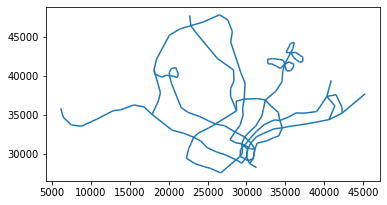

In [38]:
line_gdf.plot()

Save file

In [39]:
line_all_gdf = line_gdf.dissolve('line_name', as_index=False)

line_all_gdf.to_file('data/MRT_line.shp')
line_gdf.to_file('data/MRT_line_segement.shp')
stn_gpd.to_file('data/MRT_station.shp')